# Quick Start: OpenADR 3 Pricing Demo (openleadr-rs)

**Prerequisites:** The openleadr-rs VTN must be running with PostgreSQL. See `instructions-openleadr.ipynb` for full setup details.

```bash
cd openleadr-rs

# Start PostgreSQL
docker compose up -d db

# Run migrations & load test users (no local psql needed)
cargo sqlx migrate run
docker compose exec -T db psql -U openadr openadr < fixtures/test_user_credentials.sql

# Start the VTN
RUST_LOG=debug cargo run --bin openleadr-vtn
```

## Step 1: Setup & Verify VTN Connection

In [9]:
import requests
import json
from datetime import datetime, timedelta
import isodate

In [10]:
# --- Configuration ---
# openleadr-rs VTN runs at localhost:3000 with no path prefix
VTN_BASE_URL = "http://localhost:3000"

# Business logic credentials (from fixtures/test_user_credentials.sql)
BL_CLIENT_ID = "any-business"
BL_CLIENT_SECRET = "any-business"

# VEN credentials
VEN_CLIENT_ID = "ven-1"
VEN_CLIENT_SECRET = "ven-1"

OLIVINE_PRICING_URL = "https://api.olivineinc.com/i/oe/pricing/signal/paced/etou-dyn"


def get_token(client_id, client_secret):
    """Get an OAuth token from the VTN."""
    resp = requests.post(
        f"{VTN_BASE_URL}/auth/token",
        data={
            "grant_type": "client_credentials",
            "client_id": client_id,
            "client_secret": client_secret,
        },
    )
    resp.raise_for_status()
    return resp.json()["access_token"]


def bl_headers():
    """Return Authorization headers for Business Logic role."""
    return {"Authorization": f"Bearer {get_token(BL_CLIENT_ID, BL_CLIENT_SECRET)}"}


def ven_headers():
    """Return Authorization headers for VEN role."""
    return {"Authorization": f"Bearer {get_token(VEN_CLIENT_ID, VEN_CLIENT_SECRET)}"}


# --- Verify VTN is running ---
resp = requests.get(f"{VTN_BASE_URL}/programs", headers=bl_headers())
resp.raise_for_status()
print(f"VTN is running. Current programs: {resp.json()}")

VTN is running. Current programs: [{'id': '9dda962c-4e93-40f1-abff-250af2d2f54f', 'createdDateTime': '2026-02-18T05:02:26.040500+00:00', 'modificationDateTime': '2026-02-18T05:02:26.040500+00:00', 'objectType': 'PROGRAM', 'programName': 'etou-dynamic-pricing', 'programLongName': 'Dynamic Time-of-Use Pricing (eTOU-Dyn)', 'retailerName': 'PUC', 'retailerLongName': 'Pacific Utility Company', 'programType': 'PRICING', 'country': 'US', 'principalSubdivision': 'CA', 'payloadDescriptors': [{'objectType': 'EVENT_PAYLOAD_DESCRIPTOR', 'payloadType': 'PRICE', 'units': 'KWH', 'currency': 'USD'}]}]


## Step 2: Fetch Live Prices from Olivine API

In [11]:
# Fetch live pricing data from the Olivine API
olivine_resp = requests.get(OLIVINE_PRICING_URL, headers={"Accept": "application/json"})
olivine_resp.raise_for_status()
olivine_data = olivine_resp.json()

# Extract metadata from vtnComment
vtn_comment = olivine_data["eventDescriptor"]["vtnComment"]
metadata = dict(item.split(":", 1) for item in vtn_comment.split(";"))
print("Metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

# Extract start time using isodate
start_time_str = olivine_data["eiActivePeriod"]["properties"]["dtstart"]["datetime"]["value"]
start_time = isodate.parse_datetime(start_time_str)

# Extract price intervals
intervals = olivine_data["eiEventSignals"]["eiEventSignal"][0]["intervals"]

print(f"\nPricing window start: {start_time}")
print(f"Number of hourly intervals: {len(intervals)}")
print(f"\nHourly prices (USD/kWh):")

current_time = start_time
for interval_data in intervals:
    interval_num = int(interval_data["item"]["text"])
    price = interval_data["streamPayloadBase"][0]["item"]["value"]
    duration_str = interval_data["duration"]["duration"]
    duration = isodate.parse_duration(duration_str)
    end_time = current_time + duration
    print(f"  Hour {interval_num:2d}: ${price:.5f} ({current_time:%Y-%m-%d %H:%M} to {end_time:%Y-%m-%d %H:%M})")
    current_time = end_time

Metadata:
  BindingPrices: True
  LocalPrice: False
  RetailerLong: Pacific Utility Company
  RateNameLong: E-TOU Dynamic
  DateAnnounced: 2020-01-01
  DateStart: 2020-06-01
  URL: http://www.example.org/PUC/paced-etou-dyn

Pricing window start: 2026-02-18 05:00:00+00:00
Number of hourly intervals: 24

Hourly prices (USD/kWh):
  Hour  0: $0.12046 (2026-02-18 05:00 to 2026-02-18 06:00)
  Hour  1: $0.11859 (2026-02-18 06:00 to 2026-02-18 07:00)
  Hour  2: $0.11692 (2026-02-18 07:00 to 2026-02-18 08:00)
  Hour  3: $0.11888 (2026-02-18 08:00 to 2026-02-18 09:00)
  Hour  4: $0.11710 (2026-02-18 09:00 to 2026-02-18 10:00)
  Hour  5: $0.11624 (2026-02-18 10:00 to 2026-02-18 11:00)
  Hour  6: $0.11664 (2026-02-18 11:00 to 2026-02-18 12:00)
  Hour  7: $0.11659 (2026-02-18 12:00 to 2026-02-18 13:00)
  Hour  8: $0.12147 (2026-02-18 13:00 to 2026-02-18 14:00)
  Hour  9: $0.12621 (2026-02-18 14:00 to 2026-02-18 15:00)
  Hour 10: $0.12647 (2026-02-18 15:00 to 2026-02-18 16:00)
  Hour 11: $0.11880 (2

## Step 3: Create a Pricing Program on the VTN

In [14]:
# Create a pricing program on the VTN
# openleadr-rs supports the full OpenADR 3.0 program schema including
# programType, retailerName, country, etc.
program_data = {
    "programName": "etou-dynamic-pricing2",
    "programLongName": "Dynamic Time-of-Use Pricing (eTOU-Dyn)",
    "programType": "PRICING",
    "retailerName": "PUC",
    "retailerLongName": "Pacific Utility Company",
    "country": "US",
    "principalSubdivision": "CA",
    "payloadDescriptors": [
        {
            "objectType": "EVENT_PAYLOAD_DESCRIPTOR",
            "payloadType": "PRICE",
            "units": "KWH",
            "currency": "USD"
        }
    ]
}

resp = requests.post(
    f"{VTN_BASE_URL}/programs",
    json=program_data,
    headers=bl_headers(),
)
print(f"Status: {resp.status_code}")
print(f"Response: {resp.text}")
resp.raise_for_status()
program = resp.json()
program_id = program["id"]

print(f"\nProgram created successfully!")
print(f"Program ID: {program_id}")
print(f"\nFull response:")
print(json.dumps(program, indent=2))

Status: 201
Response: {"id":"50e0aeb5-283e-4ac4-a0ac-618c8c5a190c","createdDateTime":"2026-02-18T05:05:28.580891+00:00","modificationDateTime":"2026-02-18T05:05:28.580891+00:00","objectType":"PROGRAM","programName":"etou-dynamic-pricing2","programLongName":"Dynamic Time-of-Use Pricing (eTOU-Dyn)","retailerName":"PUC","retailerLongName":"Pacific Utility Company","programType":"PRICING","country":"US","principalSubdivision":"CA","payloadDescriptors":[{"objectType":"EVENT_PAYLOAD_DESCRIPTOR","payloadType":"PRICE","units":"KWH","currency":"USD"}]}

Program created successfully!
Program ID: 50e0aeb5-283e-4ac4-a0ac-618c8c5a190c

Full response:
{
  "id": "50e0aeb5-283e-4ac4-a0ac-618c8c5a190c",
  "createdDateTime": "2026-02-18T05:05:28.580891+00:00",
  "modificationDateTime": "2026-02-18T05:05:28.580891+00:00",
  "objectType": "PROGRAM",
  "programName": "etou-dynamic-pricing2",
  "programLongName": "Dynamic Time-of-Use Pricing (eTOU-Dyn)",
  "retailerName": "PUC",
  "retailerLongName": "Pacif

## Step 4: Publish Price Signal as an Event

Convert the Olivine pricing data into an OpenADR 3 event and publish it to the VTN.

In [15]:
# Convert Olivine pricing data to an OpenADR 3 event
event_data = {
    "eventName": f"etou-dyn-{olivine_data['eventDescriptor']['eventID']}",
    "programID": program_id,
    "intervalPeriod": {
        "start": start_time.isoformat(),
        "duration": "PT1H"
    },
    "payloadDescriptors": [
        {
            "objectType": "EVENT_PAYLOAD_DESCRIPTOR",
            "payloadType": "PRICE",
            "units": "KWH",
            "currency": "USD"
        }
    ],
    "intervals": [
        {
            "id": int(interval_data["item"]["text"]),
            "payloads": [{"type": "PRICE", "values": [round(interval_data["streamPayloadBase"][0]["item"]["value"], 5)]}]
        }
        for interval_data in intervals
    ]
}

resp = requests.post(
    f"{VTN_BASE_URL}/events",
    json=event_data,
    headers=bl_headers(),
)
print(f"Status: {resp.status_code}")
print(f"Response: {resp.text}")
resp.raise_for_status()
event = resp.json()

print(f"\nEvent created successfully!")
print(f"Event ID: {event['id']}")
print(f"Intervals published: {len(event['intervals'])}")
print(f"\nFull response:")
print(json.dumps(event, indent=2))

Status: 201
Response: {"id":"a8e2149b-f989-4d8f-bc19-fc2dc8456cdc","createdDateTime":"2026-02-18T05:05:30.022319+00:00","modificationDateTime":"2026-02-18T05:05:30.022319+00:00","objectType":"EVENT","programID":"50e0aeb5-283e-4ac4-a0ac-618c8c5a190c","eventName":"etou-dyn-PUC-paced-etou-dyn-2026-02-17","priority":null,"payloadDescriptors":[{"payloadType":"PRICE","units":"KWH","currency":"USD"}],"intervalPeriod":{"start":"2026-02-18T05:00:00+00:00","duration":"P0Y0M0DT1H0M0S"},"intervals":[{"id":0,"payloads":[{"type":"PRICE","values":[0.12046]}]},{"id":1,"payloads":[{"type":"PRICE","values":[0.11859]}]},{"id":2,"payloads":[{"type":"PRICE","values":[0.11692]}]},{"id":3,"payloads":[{"type":"PRICE","values":[0.11888]}]},{"id":4,"payloads":[{"type":"PRICE","values":[0.1171]}]},{"id":5,"payloads":[{"type":"PRICE","values":[0.11624]}]},{"id":6,"payloads":[{"type":"PRICE","values":[0.11664]}]},{"id":7,"payloads":[{"type":"PRICE","values":[0.11659]}]},{"id":8,"payloads":[{"type":"PRICE","values"

## Step 5: Read Events as a VEN

Authenticate as a VEN client and read the pricing events from the VTN — this is what a water heater controller would do.

In [16]:
# Read all events as a VEN
resp = requests.get(f"{VTN_BASE_URL}/events", headers=ven_headers())
resp.raise_for_status()
events = resp.json()

print(f"Number of events: {len(events)}")
for evt in events:
    print(f"\n--- Event: {evt.get('eventName', evt['id'])} ---")
    print(f"  Program ID: {evt['programID']}")
    print(f"  Start: {evt.get('intervalPeriod', {}).get('start', 'N/A')}")
    print(f"  Intervals: {len(evt['intervals'])}")
    print(f"  Prices (USD/kWh):")
    for interval in evt["intervals"]:
        for payload in interval["payloads"]:
            if payload["type"] == "PRICE":
                print(f"    Hour {interval['id']:2d}: ${payload['values'][0]:.5f}")

Number of events: 3

--- Event: etou-dyn-PUC-paced-etou-dyn-2026-02-17 ---
  Program ID: 50e0aeb5-283e-4ac4-a0ac-618c8c5a190c
  Start: 2026-02-18T05:00:00+00:00
  Intervals: 24
  Prices (USD/kWh):
    Hour  0: $0.12046
    Hour  1: $0.11859
    Hour  2: $0.11692
    Hour  3: $0.11888
    Hour  4: $0.11710
    Hour  5: $0.11624
    Hour  6: $0.11664
    Hour  7: $0.11659
    Hour  8: $0.12147
    Hour  9: $0.12621
    Hour 10: $0.12647
    Hour 11: $0.11880
    Hour 12: $0.11455
    Hour 13: $0.11120
    Hour 14: $0.10689
    Hour 15: $0.10519
    Hour 16: $0.10300
    Hour 17: $0.10620
    Hour 18: $0.10930
    Hour 19: $0.11764
    Hour 20: $0.12748
    Hour 21: $0.12872
    Hour 22: $0.12799
    Hour 23: $0.12398

--- Event: etou-dyn-PUC-paced-etou-dyn-2026-02-17 ---
  Program ID: 9dda962c-4e93-40f1-abff-250af2d2f54f
  Start: 2026-02-18T05:00:00+00:00
  Intervals: 24
  Prices (USD/kWh):
    Hour  0: $0.12046
    Hour  1: $0.11859
    Hour  2: $0.11692
    Hour  3: $0.11888
    Hour  

## Step 6: Run Easy Shift Control Algorithm

Use the Easy Shift algorithm to convert the price signals from the VTN into an optimal heat pump water heater operation schedule. The algorithm ranks hours by electricity cost and shifts load to the cheapest hours while respecting thermal storage constraints.

**Parameters below are for a typical residential heat pump water heater (HPWH):**
- 80-gallon tank (~300 kWh thermal capacity)
- 4.5 kW heat pump output
- COP ~3.0 (constant for simplicity)
- Assumed uniform hot water draw profile across the pricing window

Horizon: 24 hours
Prices ($/kWh): [0.12046, 0.11859, 0.11692, 0.11888, 0.1171, 0.11624, 0.11664, 0.11659, 0.12147, 0.12621, 0.12647, 0.1188, 0.11455, 0.1112, 0.10689, 0.10519, 0.103, 0.1062, 0.1093, 0.11764, 0.12748, 0.12872, 0.12799, 0.12398]

Next unsatisfied hour: 3
  Hour 2: max control (4.5) fits within storage.
  Hour 2: reduced to 2.5 (cheaper hour at 5).

Next unsatisfied hour: 5
  Hour 5: max control (4.5) fits within storage.

Next unsatisfied hour: 8
  Hour 7: max control (4.5) fits within storage.

Next unsatisfied hour: 11
  Hour 6: max control (4.5) fits within storage.
  Hour 6: reduced to 1.5 (cheaper hour at 12).

Next unsatisfied hour: 12
  Hour 12: max control (4.5) fits within storage.
  Hour 12: reduced to 1.5 (cheaper hour at 13).

Next unsatisfied hour: 13
  Hour 13: max control (4.5) fits within storage.
  Hour 13: reduced to 1.5 (cheaper hour at 14).

Next unsatisfied hour: 14
  Hour 14: max control (4.5) fits within storage.
  Hour 14: reduced to 1.5 (cheaper 

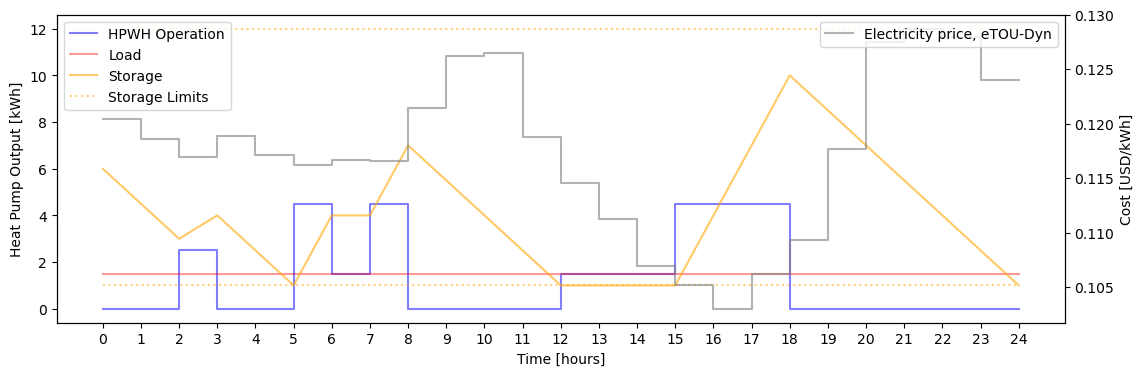

In [20]:
from controls import easy_shift, get_storage, iteration_plot

# --- Extract prices from the VEN event (Step 5) ---
# Use the first event's price intervals
evt = events[0]
prices = []
for interval in sorted(evt["intervals"], key=lambda x: x["id"]):
    for payload in interval["payloads"]:
        if payload["type"] == "PRICE":
            prices.append(payload["values"][0])

horizon = len(prices)
print(f"Horizon: {horizon} hours")
print(f"Prices ($/kWh): {prices}")

# --- HPWH parameters ---
max_hp_output = 4.5      # kW (heat pump max thermal output)
min_hp_output = 0.0      # kW (fully variable speed)
max_storage = 12.0       # kWh (80-gal tank thermal capacity)
min_storage = 1.0        # kWh (keep small reserve)
initial_soc = 6.0        # kWh (start half full)
cop = 3.0                # constant COP for simplicity

# Assume uniform hot water draw across the window
avg_draw = 1.5  # kWh per hour (typical residential draw)
load_per_hour = [avg_draw] * horizon

parameters = {
    "horizon": horizon,
    "elec_costs": prices,
    "load": {"type": "hourly", "value": load_per_hour},
    "control": {
        "max": [max_hp_output] * horizon,
        "min": [min_hp_output] * horizon,
        "units": "Heat Pump Output [kWh]",
        "name": "HPWH Operation",
    },
    "constraints": {
        "storage_capacity": True,
        "max_storage": max_storage,
        "min_storage": min_storage,
        "initial_soc": initial_soc,
        "cheaper_hours": True,
    },
    "hardware": {
        "heatpump": True,
        "COP": [cop] * horizon,
    },
    "price_structure_name": "eTOU-Dyn",
}

# --- Run Easy Shift ---
operation, converged = easy_shift(parameters, verbose=True)

print(f"\nConverged: {converged}")
print(f"\nHourly schedule (kWh):")
for i in range(horizon):
    on_off = "ON " if operation["control"][i] > 0 else "OFF"
    print(f"  Hour {i:2d}: {on_off}  {operation['control'][i]:5.2f} kWh  @ ${prices[i]:.5f}/kWh  cost=${operation['cost'][i]:.5f}")

print(f"\nTotal electricity cost: ${sum(operation['cost']):.5f}")

# --- Plot ---
iteration_plot(operation, parameters)